In [ ]:
# !sudo apt install swig

In [ ]:
# !pip install quantstats
# !pip install scikit-learn
# !pip install torch
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
#!pip install vmdpy

In [3]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import torch
import os
import shutil
import numpy as np

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import GroupByScaler
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [4]:
TEST_SET = [
    "AAPL", "CVX", "GS", "JNJ",
    "JPM", "MSFT", "PFE", "PG",
    "UL", "XOM"
]
START_DATE = '2013-01-01'
END_DATE = '2023-12-31'
print(len(TEST_SET))

portfolio_raw_df = YahooDownloader(start_date = START_DATE,
                                end_date = END_DATE,
                                ticker_list = TEST_SET).fetch_data()
portfolio_raw_df
portfolio_raw_df.groupby("tic").count()
portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(portfolio_raw_df)
portfolio_norm_df
df_portfolio = portfolio_norm_df[["date", "tic", "close", "high", "low"]]

df_portfolio_train = df_portfolio[(df_portfolio["date"] >= START_DATE) & (df_portfolio["date"] < "2020-12-31")]
df_portfolio_2021 = df_portfolio[(df_portfolio["date"] >= "2021-01-01") & (df_portfolio["date"] < "2021-12-31")]
df_portfolio_2022 = df_portfolio[(df_portfolio["date"] >= "2022-01-01") & (df_portfolio["date"] < "2022-12-31")]
df_portfolio_2023 = df_portfolio[(df_portfolio["date"] >= "2023-01-01") & (df_portfolio["date"] < END_DATE)]

10


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (27680, 8)



/Users/ethan/Documents/GitHub/DSE4212/venv/lib/python3.10/site-packages/finrl/meta/preprocessor/preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.38369243 0.24161592 0.40684028 ... 0.03291756 0.02330824 0.02918077]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
/Users/ethan/Documents/GitHub/DSE4212/venv/lib/python3.10/site-packages/finrl/meta/preprocessor/preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.5  0.75 1.   ... 0.5  0.75 1.  ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(


In [5]:
import pandas as pd
from vmdpy import VMD

def apply_vmd_to_ticker(df, alpha=5000, tau=0, K=3, DC=0, init=1, tol=1e-7):
    """Applies VMD to the 'close' price for each ticker in the dataframe
    and handles any length mismatch issues."""
    vmd_features = []
    
    # Apply VMD per ticker
    for tic in df['tic'].unique():
        tic_df = df[df['tic'] == tic].copy()  # Filter data for the current ticker
        close_prices = tic_df['close'].to_numpy()  # Extract close prices
        
        # Perform VMD on the close prices
        u, _, _ = VMD(close_prices, alpha, tau, K, DC, init, tol)
        
        # Check if the lengths match, and if not, align them
        if u.shape[1] != len(tic_df):
            print(f"Length mismatch for {tic}: VMD output has {u.shape[1]} points, expected {len(tic_df)}")
            min_len = min(u.shape[1], len(tic_df))
            tic_df = tic_df.iloc[:min_len]  # Truncate the dataframe to match VMD output length
            u = u[:, :min_len]  # Truncate VMD output if necessary
        
        # Assign VMD modes to columns
        for k in range(K):
            tic_df[f'vmd_mode_{k}'] = u[k, :]
        
        # Append the dataframe with VMD modes
        vmd_features.append(tic_df)
    
    # Concatenate all VMD modes into one dataframe
    vmd_df = pd.concat(vmd_features, axis=0)
    
    return vmd_df

# Apply VMD to the training data
df_portfolio_train_vmd = apply_vmd_to_ticker(df_portfolio_train)
df_portfolio_2021_vmd = apply_vmd_to_ticker(df_portfolio_2021)
df_portfolio_2022_vmd = apply_vmd_to_ticker(df_portfolio_2022)
df_portfolio_2023_vmd = apply_vmd_to_ticker(df_portfolio_2023)


Length mismatch for AAPL: VMD output has 250 points, expected 251
Length mismatch for CVX: VMD output has 250 points, expected 251
Length mismatch for GS: VMD output has 250 points, expected 251
Length mismatch for JNJ: VMD output has 250 points, expected 251
Length mismatch for JPM: VMD output has 250 points, expected 251
Length mismatch for MSFT: VMD output has 250 points, expected 251
Length mismatch for PFE: VMD output has 250 points, expected 251
Length mismatch for PG: VMD output has 250 points, expected 251
Length mismatch for UL: VMD output has 250 points, expected 251
Length mismatch for XOM: VMD output has 250 points, expected 251
Length mismatch for AAPL: VMD output has 250 points, expected 251
Length mismatch for CVX: VMD output has 250 points, expected 251
Length mismatch for GS: VMD output has 250 points, expected 251
Length mismatch for JNJ: VMD output has 250 points, expected 251
Length mismatch for JPM: VMD output has 250 points, expected 251
Length mismatch for MSFT: 

In [13]:
TIME_WINDOW = 100
COMISSION_FEE = 0.0025
FEATURE_NAMES = ["close", "high", "low", "vmd_mode_0", "vmd_mode_1", "vmd_mode_2"]
environment_vmd = PortfolioOptimizationEnv(
    df=df_portfolio_train_vmd,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,  # Add VMD modes as features
    normalize_df=None,
    reward_scaling=1.0,
)


# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": TIME_WINDOW,
    "initial_features": len(FEATURE_NAMES),
}

model = DRLAgent(environment_vmd).get_model("pg", device, model_kwargs, policy_kwargs)

In [14]:
DRLAgent.train_model(model, episodes=30)

  0%|          | 0/30 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 261093.5
Final accumulative portfolio value: 2.610935
Maximum DrawDown: -0.2256343372855636
Sharpe ratio: 0.9790274520645879


  3%|▎         | 1/30 [00:07<03:33,  7.38s/it]

Initial portfolio value:100000
Final portfolio value: 365154.28125
Final accumulative portfolio value: 3.6515428125
Maximum DrawDown: -0.16624983490732836
Sharpe ratio: 1.3013128855964502


  7%|▋         | 2/30 [00:15<03:31,  7.54s/it]

Initial portfolio value:100000
Final portfolio value: 385199.8125
Final accumulative portfolio value: 3.851998125
Maximum DrawDown: -0.2045302648396352
Sharpe ratio: 1.2496356260256571


 10%|█         | 3/30 [00:23<03:32,  7.87s/it]

Initial portfolio value:100000
Final portfolio value: 724113.625
Final accumulative portfolio value: 7.24113625
Maximum DrawDown: -0.19601241188398788
Sharpe ratio: 1.5057296244515321


 13%|█▎        | 4/30 [00:31<03:25,  7.91s/it]

Initial portfolio value:100000
Final portfolio value: 792569.75
Final accumulative portfolio value: 7.9256975
Maximum DrawDown: -0.21678308782053846
Sharpe ratio: 1.4314828073727817


 17%|█▋        | 5/30 [00:39<03:19,  7.99s/it]

Initial portfolio value:100000
Final portfolio value: 257039.140625
Final accumulative portfolio value: 2.57039140625
Maximum DrawDown: -0.15813226364590904
Sharpe ratio: 0.9971598130984807


 20%|██        | 6/30 [00:47<03:12,  8.01s/it]

Initial portfolio value:100000
Final portfolio value: 825899.8125
Final accumulative portfolio value: 8.258998125
Maximum DrawDown: -0.28258978690108827
Sharpe ratio: 1.2456813513435894


 23%|██▎       | 7/30 [00:54<02:59,  7.80s/it]

Initial portfolio value:100000
Final portfolio value: 1107851.75
Final accumulative portfolio value: 11.0785175
Maximum DrawDown: -0.19123218115093976
Sharpe ratio: 1.5813097843632953


 27%|██▋       | 8/30 [01:02<02:49,  7.72s/it]

Initial portfolio value:100000
Final portfolio value: 1278158.625
Final accumulative portfolio value: 12.78158625
Maximum DrawDown: -0.197842153852686
Sharpe ratio: 1.565418796114298


 30%|███       | 9/30 [01:09<02:40,  7.66s/it]

Initial portfolio value:100000
Final portfolio value: 411958.5625
Final accumulative portfolio value: 4.119585625
Maximum DrawDown: -0.17644617083930403
Sharpe ratio: 1.2308621534592068


 33%|███▎      | 10/30 [01:17<02:33,  7.66s/it]

Initial portfolio value:100000
Final portfolio value: 1158413.5
Final accumulative portfolio value: 11.584135
Maximum DrawDown: -0.2575562612099668
Sharpe ratio: 1.4434838833100407


 37%|███▋      | 11/30 [01:25<02:24,  7.62s/it]

Initial portfolio value:100000
Final portfolio value: 572288.1875
Final accumulative portfolio value: 5.722881875
Maximum DrawDown: -0.1567462809137231
Sharpe ratio: 1.2738894222360502


 40%|████      | 12/30 [01:32<02:16,  7.58s/it]

Initial portfolio value:100000
Final portfolio value: 731388.8125
Final accumulative portfolio value: 7.313888125
Maximum DrawDown: -0.3315468010311474
Sharpe ratio: 1.1617859949856664


 43%|████▎     | 13/30 [01:40<02:10,  7.68s/it]

Initial portfolio value:100000
Final portfolio value: 249455.828125
Final accumulative portfolio value: 2.49455828125
Maximum DrawDown: -0.33469034521786967
Sharpe ratio: 0.6427804347065755


 47%|████▋     | 14/30 [01:48<02:05,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 198574.34375
Final accumulative portfolio value: 1.9857434375
Maximum DrawDown: -0.34638045499288284
Sharpe ratio: 0.5167919530130531


 50%|█████     | 15/30 [01:56<01:59,  7.98s/it]

Initial portfolio value:100000
Final portfolio value: 263995.8125
Final accumulative portfolio value: 2.639958125
Maximum DrawDown: -0.3089770041878157
Sharpe ratio: 0.6522257392034186


 53%|█████▎    | 16/30 [02:05<01:52,  8.02s/it]

Initial portfolio value:100000
Final portfolio value: 834974.125
Final accumulative portfolio value: 8.34974125
Maximum DrawDown: -0.24533390280675393
Sharpe ratio: 1.2729257026281713


 57%|█████▋    | 17/30 [02:13<01:43,  8.00s/it]

Initial portfolio value:100000
Final portfolio value: 1426938.0
Final accumulative portfolio value: 14.26938
Maximum DrawDown: -0.25850062218981473
Sharpe ratio: 1.5545500949122537


 60%|██████    | 18/30 [02:20<01:35,  7.96s/it]

Initial portfolio value:100000
Final portfolio value: 1136575.75
Final accumulative portfolio value: 11.3657575
Maximum DrawDown: -0.2414137773093632
Sharpe ratio: 1.5186434703258591


 63%|██████▎   | 19/30 [02:28<01:25,  7.79s/it]

Initial portfolio value:100000
Final portfolio value: 677099.4375
Final accumulative portfolio value: 6.770994375
Maximum DrawDown: -0.29264974613364014
Sharpe ratio: 1.3168587339525655


 67%|██████▋   | 20/30 [02:35<01:16,  7.66s/it]

Initial portfolio value:100000
Final portfolio value: 1447166.875
Final accumulative portfolio value: 14.47166875
Maximum DrawDown: -0.3676966784907514
Sharpe ratio: 1.4601439755569685


 70%|███████   | 21/30 [02:44<01:12,  8.03s/it]

Initial portfolio value:100000
Final portfolio value: 1373524.375
Final accumulative portfolio value: 13.73524375
Maximum DrawDown: -0.2707240688162863
Sharpe ratio: 1.4788687301616426


 73%|███████▎  | 22/30 [02:53<01:05,  8.16s/it]

Initial portfolio value:100000
Final portfolio value: 2101949.25
Final accumulative portfolio value: 21.0194925
Maximum DrawDown: -0.22528064996400565
Sharpe ratio: 1.7181381535335392


 77%|███████▋  | 23/30 [03:01<00:57,  8.15s/it]

Initial portfolio value:100000
Final portfolio value: 806834.125
Final accumulative portfolio value: 8.06834125
Maximum DrawDown: -0.3132879731308891
Sharpe ratio: 1.2182697116678336


 80%|████████  | 24/30 [03:08<00:47,  7.97s/it]

Initial portfolio value:100000
Final portfolio value: 1496573.875
Final accumulative portfolio value: 14.96573875
Maximum DrawDown: -0.2500297190566877
Sharpe ratio: 1.542705621036644


 83%|████████▎ | 25/30 [03:16<00:38,  7.78s/it]

Initial portfolio value:100000
Final portfolio value: 2575013.25
Final accumulative portfolio value: 25.7501325
Maximum DrawDown: -0.230579461572327
Sharpe ratio: 1.8337479943475916


 87%|████████▋ | 26/30 [03:23<00:30,  7.70s/it]

Initial portfolio value:100000
Final portfolio value: 2199369.5
Final accumulative portfolio value: 21.993695
Maximum DrawDown: -0.2833732642356954
Sharpe ratio: 1.6569349218134737


 90%|█████████ | 27/30 [03:31<00:23,  7.80s/it]

Initial portfolio value:100000
Final portfolio value: 1243332.125
Final accumulative portfolio value: 12.43332125
Maximum DrawDown: -0.22123414510022477
Sharpe ratio: 1.5412687324872447


 93%|█████████▎| 28/30 [03:39<00:15,  7.79s/it]

Initial portfolio value:100000
Final portfolio value: 922961.5625
Final accumulative portfolio value: 9.229615625
Maximum DrawDown: -0.24844036751498155
Sharpe ratio: 1.288080458545072


 97%|█████████▋| 29/30 [03:47<00:07,  7.87s/it]

Initial portfolio value:100000
Final portfolio value: 972422.8125
Final accumulative portfolio value: 9.724228125
Maximum DrawDown: -0.2816453717505568
Sharpe ratio: 1.3254500678377552


100%|██████████| 30/30 [03:54<00:00,  7.83s/it]


In [15]:
torch.save(model.train_policy.state_dict(), "policy_with_VMD.pt")

Evaluation

In [16]:
environment_2021 = PortfolioOptimizationEnv(
    df_portfolio_2021_vmd,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,
    normalize_df=None,
    reward_scaling=1.0,
)

environment_2022 = PortfolioOptimizationEnv(
    df_portfolio_2022_vmd,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,
    normalize_df=None,
    reward_scaling=1.0,
)

environment_2023 = PortfolioOptimizationEnv(
    df_portfolio_2023_vmd,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,
    normalize_df=None,
    reward_scaling=1.0,
)

EIIE_results = {
    "train": {},
    "2021": {},
    "2022": {},
    "2023": {}
}

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=TIME_WINDOW,initial_features=len(FEATURE_NAMES), device=device)
policy.load_state_dict(torch.load("policy_with_VMD.pt"))
environment_vmd.reset()

src_folder = "results/rl"
dst_folder = "results/train"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(model, environment_vmd, policy=policy)
os.rename(src_folder, dst_folder)
EIIE_results["train"]["value"] = environment_vmd._asset_memory["final"]
EIIE_results["train"]["actions"] = environment_vmd._actions_memory

# 2021
src_folder = "results/rl"
dst_folder = "results/2021"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(model, environment_2021, policy=policy)
os.rename(src_folder, dst_folder)
EIIE_results["2021"]["value"] = environment_2021._asset_memory["final"]
EIIE_results["2021"]["actions"] = environment_2021._actions_memory


# 2022
src_folder = "results/rl"
dst_folder = "results/2022"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(model, environment_2022, policy=policy)
os.rename(src_folder, dst_folder)
EIIE_results["2022"]["value"] = environment_2022._asset_memory["final"]
EIIE_results["2022"]["actions"] = environment_2022._actions_memory


# 2023
src_folder = "results/rl"
dst_folder = "results/2023"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(model, environment_2023, policy=policy)
os.rename(src_folder, dst_folder)
EIIE_results["2023"]["value"] = environment_2023._asset_memory["final"]
EIIE_results["2023"]["actions"] = environment_2023._actions_memory


#uniform buy n hold
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
UBAH_results = {
    "train": {},
    "2021": {},
    "2022": {},
    "2023": {}
}

PORTFOLIO_SIZE = len(TEST_SET)

# train period
terminated = False
environment_vmd.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_vmd.step(action)
UBAH_results["train"]["value"] = environment_vmd._asset_memory["final"]

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]

# 2023
terminated = False
environment_2023.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2023.step(action)
UBAH_results["2023"]["value"] = environment_2023._asset_memory["final"]

/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_5857/3015494156.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load("policy_wit

Initial portfolio value:100000
Final portfolio value: 1535366.125
Final accumulative portfolio value: 15.35366125
Maximum DrawDown: -0.23788326835710105
Sharpe ratio: 1.7206009186553999
Initial portfolio value:100000
Final portfolio value: 138400.3125
Final accumulative portfolio value: 1.384003125
Maximum DrawDown: -0.057164782308858686
Sharpe ratio: 3.0257374123062903
Initial portfolio value:100000
Final portfolio value: 104236.96875
Final accumulative portfolio value: 1.0423696875
Maximum DrawDown: -0.16656702888485053
Sharpe ratio: 0.377418013169383
Initial portfolio value:100000
Final portfolio value: 79349.3359375
Final accumulative portfolio value: 0.793493359375
Maximum DrawDown: -0.3232266301347335
Sharpe ratio: -1.4855589598544363
Initial portfolio value:100000
Final portfolio value: 242561.671875
Final accumulative portfolio value: 2.42561671875
Maximum DrawDown: -0.34678755451399124
Sharpe ratio: 0.7455223905067975
Initial portfolio value:100000
Final portfolio value: 11633

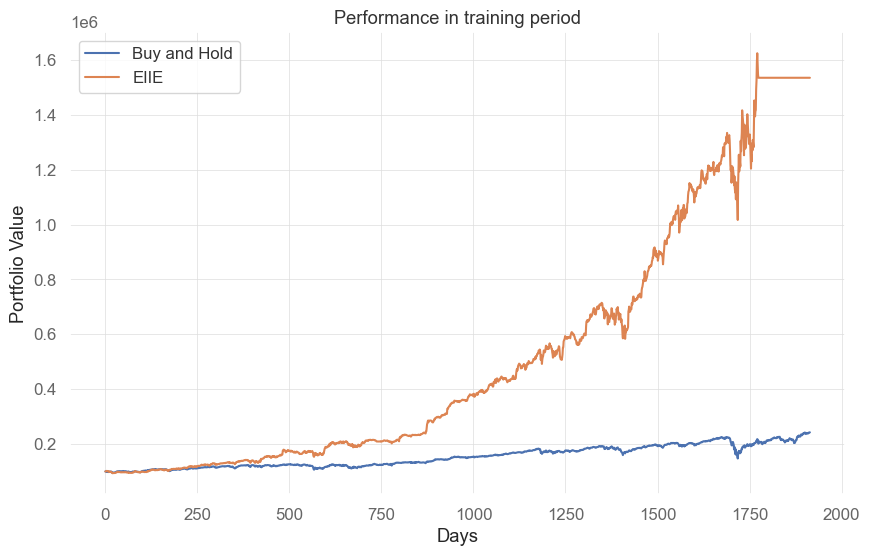

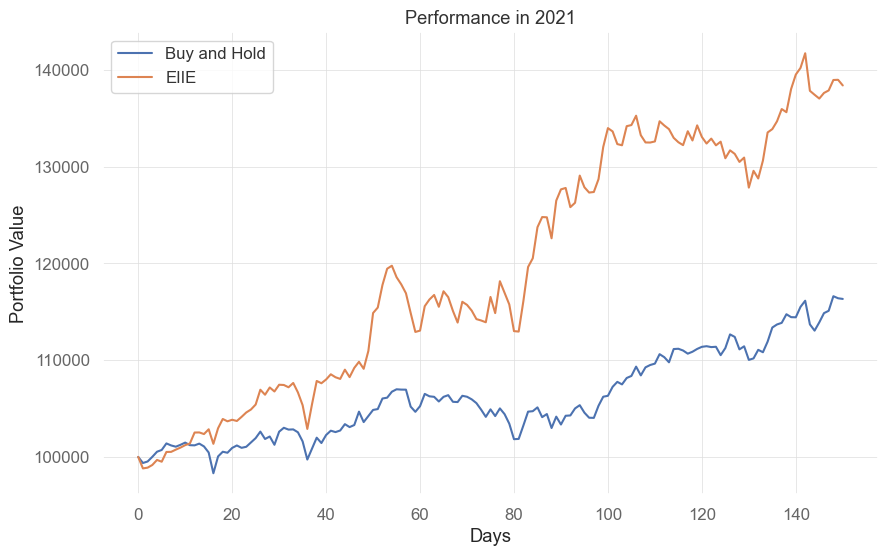

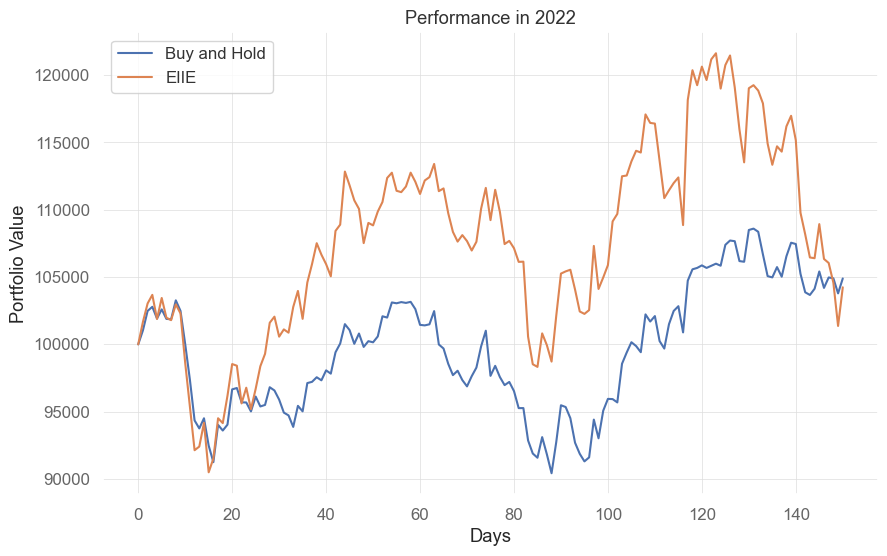

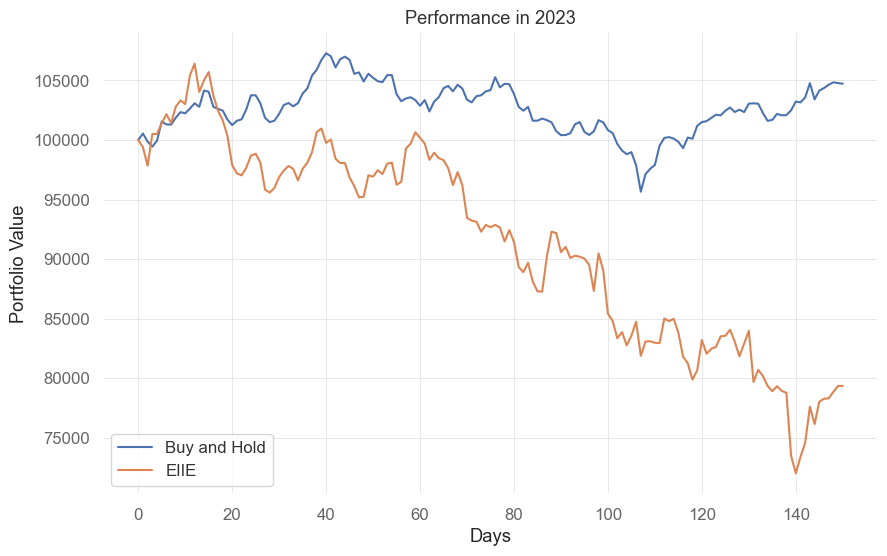

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["train"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

plt.plot(UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2021"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

plt.plot(UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2022"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()

plt.plot(UBAH_results["2023"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2023"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2023")
plt.legend()

plt.show()

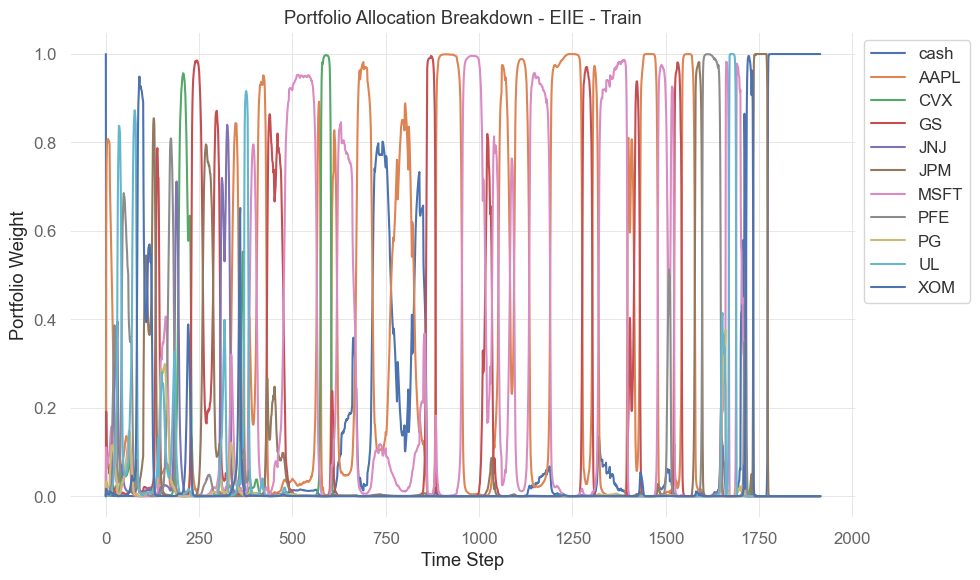

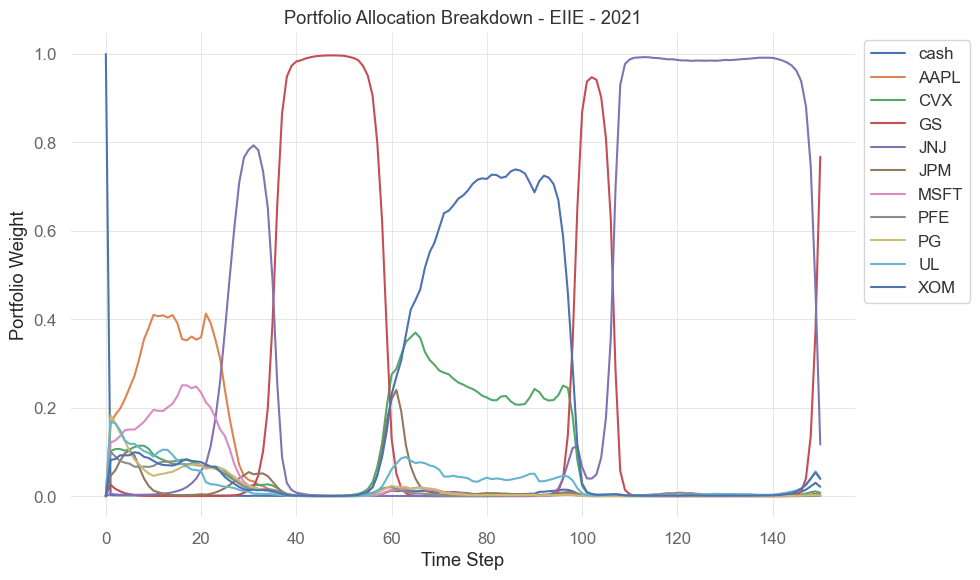

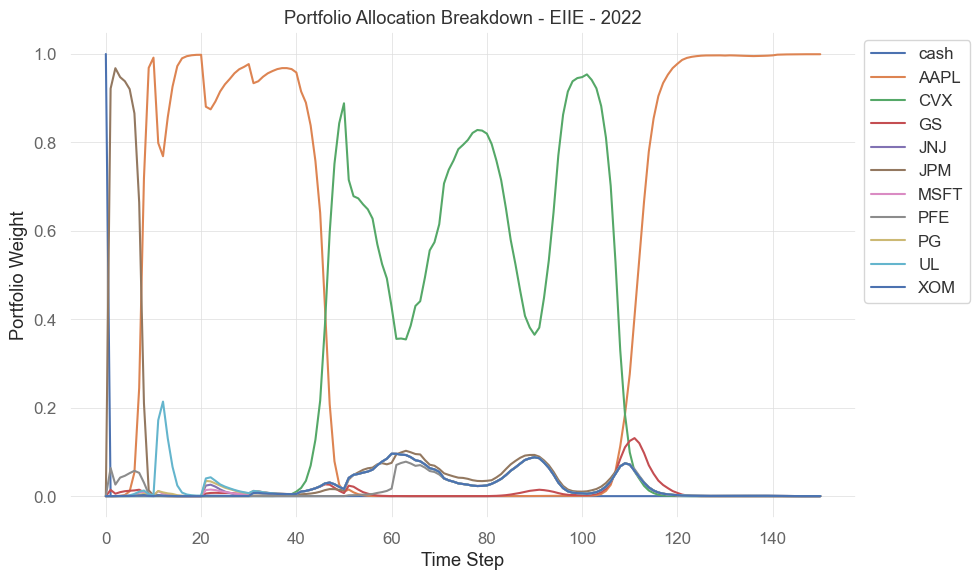

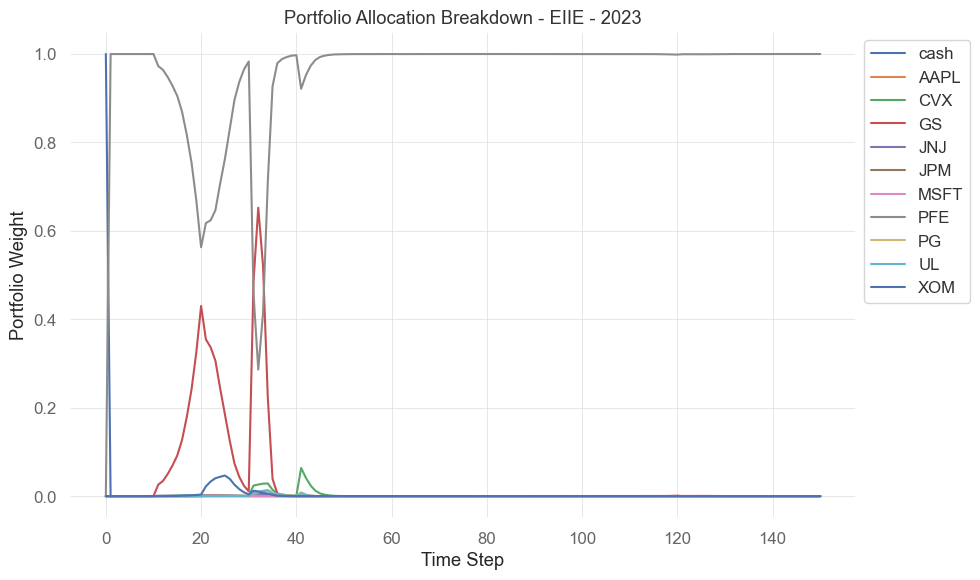

In [18]:
def plot_action_memory(actions, tickers, label):
    """Visualize portfolio allocation over time."""
    actions_df = pd.DataFrame(actions, columns=["cash"] + tickers)
    actions_df.plot(kind="line", title=f"Portfolio Allocation Breakdown - {label}")
    plt.ylabel("Portfolio Weight")
    plt.xlabel("Time Step")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot EIIE actions for the training period
plot_action_memory(EIIE_results["train"]["actions"], TEST_SET, "EIIE - Train")

# Plot EIIE actions for 2021
plot_action_memory(EIIE_results["2021"]["actions"], TEST_SET, "EIIE - 2021")

# Plot EIIE actions for 2022
plot_action_memory(EIIE_results["2022"]["actions"], TEST_SET, "EIIE - 2022")

# Plot EIIE actions for 2023
plot_action_memory(EIIE_results["2023"]["actions"], TEST_SET, "EIIE - 2023")